In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers, layers, Sequential
from tensorflow.keras.layers import Input, Dense, LeakyReLU,Conv1D,Dropout,MaxPooling1D,SimpleRNN,LocallyConnected1D
from tensorflow.keras.layers import Flatten,ReLU, BatchNormalization,AveragePooling1D, LSTM

import numpy as np

def runif():
    return tf.random.uniform([1], dtype=tf.float64)[0]
    # return tf.constant(.8, tf.float32)

def rexp():
    return -tf.math.log(runif())


def exprelu(x):
    return tf.where(x > 0, tf.math.expm1(x), tf.zeros_like(x))

def reloid(x):
    "(sigma(x[1]), ..., sigma(x[-2]), relu(x[-1])"
    return tf.concat([tf.nn.sigmoid(x[:-1]), tf.math.exp(x[-1:])], axis=0)

def reloid_derivative(x):
    return tf.concat(
        [
            tf.nn.sigmoid(x[:-1])
            * (1 - tf.nn.sigmoid(x[:-1])),  # derivative of sigmoid
            tf.math.exp(x[-1:]),
        ],
        axis=0,
    )

def S(x, w, v, b):
    """
    x: scalar
    w, v, b: (3, H)
    """
    x = tf.convert_to_tensor(x, dtype="float64")
    # tf.debugging.assert_positive(x, message="R: x>0")
    exp_w_v = tf.math.exp([w, v])
    ew = exp_w_v[0]
    ev = exp_w_v[1]
    # b = tf.math.sigmoid(b) # try this  # JT - bug. was sigb
    ew = tf.concat([ew[:-1], tf.ones_like(ew[-1:]),], axis=0,)
    x = tf.reshape(x, (1, 1))
    return tf.transpose(ev) @ reloid(ew @ x + b)

@tf.function
def R(x, w, v, b):
    return S(tf.math.log(x), w, v, b)

@tf.function
def Rinv(y, w, v, b):
    y = tf.convert_to_tensor(y, dtype="float64")
    # y = tf.reshape(y, (-1,))[0]
    # as x -> oo, R is asymyptotic to exp(v[-1] + w[-1]) x
    # fixme: calculate this exactly.
    x_left = tf.convert_to_tensor([[0.0]], tf.float64)
    x_right = tf.convert_to_tensor([[1e8]], tf.float64)
    # tf.print((x_left, x_right))
    # tf.print("y", y)
    # tf.print('y',y)
    # tf.debugging.assert_greater(R(x_right, w, v, b), y, message="R(x_right)>y inv")

    def cond(xl, xr):
        # tf.print(xl, xr)
        xi = (xl + xr) / 2.0
        yi = R(xi, w, v, b)[0, 0]
        return abs(y - yi) > 1e-6

    def body(xl, xr):
        xi = (xl + xr) / 2.0
        yi = R(xi, w, v, b)[0, 0]
        left = tf.cast(yi < y, dtype="float64")
        xl = left * xi + (1.0 - left) * xl
        xr = (1.0 - left) * xi + left * xr
        return (xl, xr)
        # print(y, x_i, y_i)

    xl, xr = tf.while_loop(cond, body, (x_left, x_right))
    return (xl + xr) / 2.0

@tf.custom_gradient
def custom_Rinv(y, w, v, b):
    y = tf.convert_to_tensor(y, dtype="float64")
    x = Rinv(y, w, v, b)
    with tf.GradientTape() as g:
        g.watch([x, w, v, b])
        y = R(x, w, v, b)
    dR_dw, dR_dv, dR_db, dR_dx = g.gradient(y, [w, v, b, x])

    def grad(dx):
        return dx / dR_dx, -dx * dR_dw / dR_dx, -dx * dR_dv / dR_dx, -dx * dR_db / dR_dx

    return x, grad

mu = 1e-4
rho = 1e-5

def _gen_gaps(k: int, _R, _Rinv,) -> tf.Tensor:
    """Return k gaps sampled from genetic distribution with rate function eta."""
    z = tf.convert_to_tensor([[rexp()]])
    x = _Rinv(z)  # initialize x by sampling from prior
    tf.debugging.assert_positive(x, message="gen_gaps first x")

    gap = tf.constant([[0.0]], dtype=tf.float64)
    j = 0
    ta = tf.TensorArray(tf.float64, size=k + 1)

    while tf.less(j, k + 1):
        # x' satisfies R(x') - R(u*x) = Z => x' = Rinv(Z + R(u*x))
        u = runif()
        z = rexp()
        u_x = tf.convert_to_tensor([[u * x]])
        r_u_x = _R(u_x)  # compute R(u_x)
        x = _Rinv(z + r_u_x)  # segment height
        # tf.print(x)
        # tf.print(z+r_u_x,"\n")
        with tf.control_dependencies(
            [
                tf.debugging.assert_all_finite(x, "second x"),
                tf.debugging.assert_positive(x, message="gen_gaps second x"),
            ]
        ):
            next_event = rexp() / (x * (mu + rho))
            tf.debugging.assert_positive(next_event, message="gen_gaps first gap")
            gap += next_event  # length to next event
        while runif() < (mu / (mu + rho)) and tf.less(j, k + 1):
            ta = ta.write(j, gap)
            gap *= 0.0
            j += 1
            next_event = rexp() / (x * (mu + rho))
            tf.debugging.assert_positive(next_event, message="gen_gaps second gap")
            gap += next_event  # length to next event

    gaps = ta.stack()[1:]  # first obs suffers from inspection paradox?
    with tf.control_dependencies(
        [
            tf.debugging.assert_positive(
                gaps, message="gaps have non-positive entry", summarize=100
            )
        ]
    ):
        return gaps


def R_learned(x, generator):
    return R(x, generator.weights[0], generator.weights[1], generator.weights[2])

thresh = tf.constant([1e-1], dtype="float64", shape=(1,))
# eta = TfPoly(x=[0., 0.1, np.inf], c=[[1/100, 1.]])
def eta(x):
    x = tf.cast(x, "float64")
    one = tf.ones(shape=[1,], dtype="float64",)
    return tf.cast(tf.where(x < thresh, 1 / 100, one), "float64")

def R_real(x):
    """R_real(x) = integral_0^x eta(t) dt"""
    x = tf.cast(x, "float64")
    x = tf.reshape(x, (1, tf.size(x)))
    tf.debugging.assert_positive(x, message="R_real: x>0")
    return tf.cast(
        tf.where(x < thresh, x / 100.0, thresh / 100.0 + (x - thresh)), "float64"
    )
    # return x


def R_real_inv(y):
    y = tf.cast(y, "float64")
    tf.debugging.assert_positive(y, message="R_real: x>0")
    return tf.cast(
        tf.where(y < thresh / 100.0, y * 100.0, y - (thresh / 100.0 - thresh)),
        "float64",
    )

@tf.function
def gen_gaps(
    w, v, b, k,
):
    R_ = lambda x: R(x, w, v, b)
    Rinv_ = lambda z: custom_Rinv(z, w, v, b)
    return _gen_gaps(k, R_, Rinv_)

@tf.function
def gen_gaps_real(k: int,):
    return _gen_gaps(k, R_real, R_real_inv,)

def discriminator_objective(d_x, g_z):
    """
    d_x = real output
    g_z = fake output
    """
    real_loss = cross_entropy(
        tf.ones_like(d_x), d_x
    )  # If we feed the discriminator with real images, we assume they all are the right pictures --> Because of that label == 1
    fake_loss = cross_entropy(
        tf.zeros_like(g_z), g_z
    )  # Each noise we feed in are fakes image --> Because of that labels are 0
    total_loss = real_loss + fake_loss

    return total_loss

In [2]:
m = tf.keras.metrics.BinaryAccuracy()
# @tf.function
def training_step(discriminator):
    with tf.GradientTape() as disc_tape:
        # both fake and real seq have shape [Batch_size, seq_len, 1]
        fake_seq = tf.reshape(tf.stack([gen_gaps(w, v, b, seq_len) for _ in range(batch_size)]),[batch_size,seq_len,1])
        real_seq = tf.reshape(tf.stack([tf.reshape(gen_gaps_real(seq_len), (1, seq_len))\
                                      for _ in range(batch_size)]),[batch_size,seq_len,1])
        d_x_true = discriminator(tf.expand_dims(tf.math.log(real_seq),-1))
        d_x_fake = discriminator(tf.expand_dims(tf.math.log(fake_seq),-1))
        
        discriminator_loss = discriminator_objective(d_x_true, d_x_fake)
        # Adjusting Gradient of Discriminator
        gradients_of_discriminator = disc_tape.gradient(
            discriminator_loss, discriminator.trainable_variables
        )
        discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )  # Takes a list of gradient and variables pairs
    m.reset_states()
    m.update_state(tf.ones_like(d_x_true),tf.math.sigmoid(d_x_true))
    real_acc = m.result()

    m.reset_states()
    m.update_state(tf.zeros_like(d_x_fake),tf.math.sigmoid(d_x_fake))
    fake_acc = m.result()

    return discriminator_loss, real_acc, fake_acc
  
def training(epoches):
    for epoch in range(epoches + 1):
        disc_loss,real,fake = training_step(discriminator)
        d_loss.append(disc_loss)
        real_acc.append(real)
        fake_acc.append(fake)
        print("epoch=%d discriminator_loss=%f real_acc=%f fake_acc=%f"
                % (epoch, disc_loss, real, fake))

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [3]:
seq_len = 1500
learning_rate = 0.005
batch_size = 64
EPOCHES = 500

# step = tf.Variable(0, trainable=False)
# boundaries = [100, 200]
# values = [0.01, 0.005, 0.001]
# learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
#     boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
# learning_rate = learning_rate_fn(step)

discriminator_optimizer = optimizers.Adam(learning_rate)

In [4]:
#upload weights.csv to colab
w,v,b=np.loadtxt('weights.csv',delimiter=',')
w = tf.expand_dims(w,-1)
v = tf.expand_dims(v,-1)
b = tf.expand_dims(b,-1)

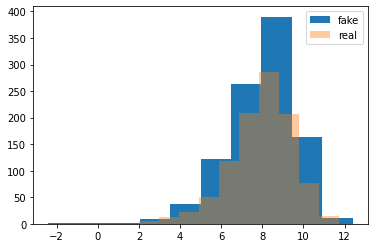

In [5]:
import matplotlib.pyplot as plt
x = tf.math.log(gen_gaps(w, v, b, 1000))
y = tf.math.log(gen_gaps_real(1000))
plt.hist(x.numpy().reshape(-1),label = 'fake')
plt.hist(y.numpy().reshape(-1), alpha=0.4,label='real')
plt.legend()
plt.show()

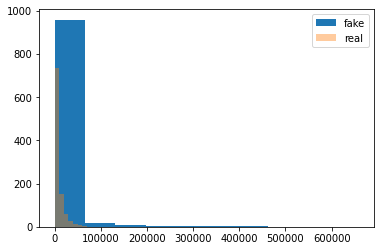

In [6]:
x = gen_gaps(w, v, b, 1000)
y = gen_gaps_real(1000)
plt.hist(x.numpy().reshape(-1),label = 'fake')
plt.hist(y.numpy().reshape(-1), alpha=0.4,label='real')
plt.legend()
plt.show()

In [7]:
discriminator = Sequential(
    [
     Input(shape=(seq_len,1)),
     LocallyConnected1D(512, 4),
     ReLU(),
     BatchNormalization(),
     LSTM(500, return_sequences=True),
        

     LocallyConnected1D(256, 4),
     ReLU(),
     BatchNormalization(),
     LSTM(250, return_sequences=True),
        
     LocallyConnected1D(128, 4),
     ReLU(),
     BatchNormalization(),
     LSTM(125, return_sequences=True),
        
     LocallyConnected1D(64, 4),
     ReLU(),
     BatchNormalization(),
     LSTM(60, return_sequences=True),
                
     LocallyConnected1D(32, 4),
     ReLU(),
     BatchNormalization(),
     LSTM(30),
        
#      LSTM(25),
#      LocallyConnected1D(28, 4),
#      ReLU(),
#      BatchNormalization(),
#      LocallyConnected1D(128, 4),
#      ReLU(),
#      MaxPooling1D(),
        
#      LocallyConnected1D(64, 4),
#      ReLU(),
#      MaxPooling1D(),
    
#      LocallyConnected1D(32, 4),
#      ReLU(),
#      MaxPooling1D(),

#      LocallyConnected1D(16, 4),
#      MaxPooling1D(),
#      ReLU(),
        
#      LocallyConnected1D(8, 4),
#      MaxPooling1D(),
#      ReLU(),
#      AveragePooling1D(),
#      Dense(30,'relu'),
#      Dense(10,'relu'),
#      Flatten(),
#      Dense(50),
#      ReLU(),
#      Dense(30),
#      ReLU(),
     Dense(1)
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
locally_connected1d (Locally (None, 1497, 512)         3832320   
_________________________________________________________________
re_lu (ReLU)                 (None, 1497, 512)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1497, 512)         2048      
_________________________________________________________________
lstm (LSTM)                  (None, 1497, 500)         2026000   
_________________________________________________________________
locally_connected1d_1 (Local (None, 1494, 256)         765310464 
_________________________________________________________________
re_lu_1 (ReLU)               (None, 1494, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1494, 256)       

In [ ]:
d_loss = []
real_acc = []
fake_acc = []
training(EPOCHES)

epoch=0 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=1 discriminator_loss=1.386294 real_acc=1.000000 fake_acc=0.000000
epoch=2 discriminator_loss=1.386513 real_acc=0.000000 fake_acc=1.000000
epoch=3 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=4 discriminator_loss=1.386374 real_acc=1.000000 fake_acc=0.000000
epoch=5 discriminator_loss=1.386366 real_acc=1.000000 fake_acc=0.000000
epoch=6 discriminator_loss=1.386298 real_acc=1.000000 fake_acc=0.000000
epoch=7 discriminator_loss=1.386341 real_acc=0.000000 fake_acc=1.000000
epoch=8 discriminator_loss=1.386337 real_acc=0.000000 fake_acc=1.000000
epoch=9 discriminator_loss=1.386297 real_acc=0.000000 fake_acc=1.000000
epoch=10 discriminator_loss=1.386302 real_acc=1.000000 fake_acc=0.000000
epoch=11 discriminator_loss=1.386318 real_acc=1.000000 fake_acc=0.000000
epoch=12 discriminator_loss=1.386316 real_acc=1.000000 fake_acc=0.000000
epoch=13 discriminator_loss=1.386301 real_acc=1.000000 fake_a

epoch=113 discriminator_loss=1.386294 real_acc=1.000000 fake_acc=0.000000
epoch=114 discriminator_loss=1.386294 real_acc=1.000000 fake_acc=0.000000
epoch=115 discriminator_loss=1.386294 real_acc=1.000000 fake_acc=0.000000
epoch=116 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=117 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=118 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=119 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=120 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=121 discriminator_loss=1.386294 real_acc=1.000000 fake_acc=0.000000
epoch=122 discriminator_loss=1.386294 real_acc=1.000000 fake_acc=0.000000
epoch=123 discriminator_loss=1.386294 real_acc=1.000000 fake_acc=0.000000
epoch=124 discriminator_loss=1.386294 real_acc=1.000000 fake_acc=0.000000
epoch=125 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=126 discriminator_loss=1.386294 

epoch=224 discriminator_loss=1.386294 real_acc=1.000000 fake_acc=0.000000
epoch=225 discriminator_loss=1.386294 real_acc=1.000000 fake_acc=0.000000
epoch=226 discriminator_loss=1.386294 real_acc=1.000000 fake_acc=0.000000
epoch=227 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=228 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=229 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=230 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=231 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=232 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=233 discriminator_loss=1.386294 real_acc=1.000000 fake_acc=0.000000
epoch=234 discriminator_loss=1.386294 real_acc=1.000000 fake_acc=0.000000
epoch=235 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=236 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=237 discriminator_loss=1.386294 

epoch=335 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=336 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=337 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=338 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=339 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=340 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=341 discriminator_loss=1.386294 real_acc=1.000000 fake_acc=0.000000
epoch=342 discriminator_loss=1.386294 real_acc=1.000000 fake_acc=0.000000
epoch=343 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=344 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=345 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=346 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=347 discriminator_loss=1.386294 real_acc=0.000000 fake_acc=1.000000
epoch=348 discriminator_loss=1.386294 

In [ ]:
plt.figure(figsize = (21,8))
plt.plot(range(len(real_acc)), (np.array(real_acc)+np.array(fake_acc))/2)

In [ ]:
B = 20
W = np.hamming(B)
W /= W.sum()
plt.figure(figsize = (21,8))
plt.plot(range(len(real_acc)),np.convolve(real_acc, W, mode='same'),label='real')
plt.plot(range(len(real_acc)),np.convolve(fake_acc, W, mode='same'),label='fake')
plt.legend()
plt.show()

In [ ]:
tf.keras.applications.MobileNetV2().summary()